In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from tqdm import tqdm

%matplotlib inline

### Preprocess funnction

In [8]:
import re
def pre_process(text):
    
    
 #Data Cleaning
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

# keyword extraction

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [149]:
#this is a mapping of index to 
feature_names=tfidf.get_feature_names()
 
# get the document that we want to extract keywords from
doc=X['text']
 
#generate tf-idf for the given document
tf_idf_vector=tfidf.transform(doc)
 
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
 
#extract only the top n
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 

print("\n===Keywords===")
x = []
values = []
for k in keywords:
    x.append(k)
    values.append(keywords[k])
    print(k,keywords[k])


===Keywords===
belvita 0.605
silva 0.571
cordiale apprezzato 0.566
super super 0.537
veramente accogliente 0.514
disponibile preparato 0.508
cortesia servizi 0.496
affascinanti servizio 0.492
otel 0.487
bla 0.486


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


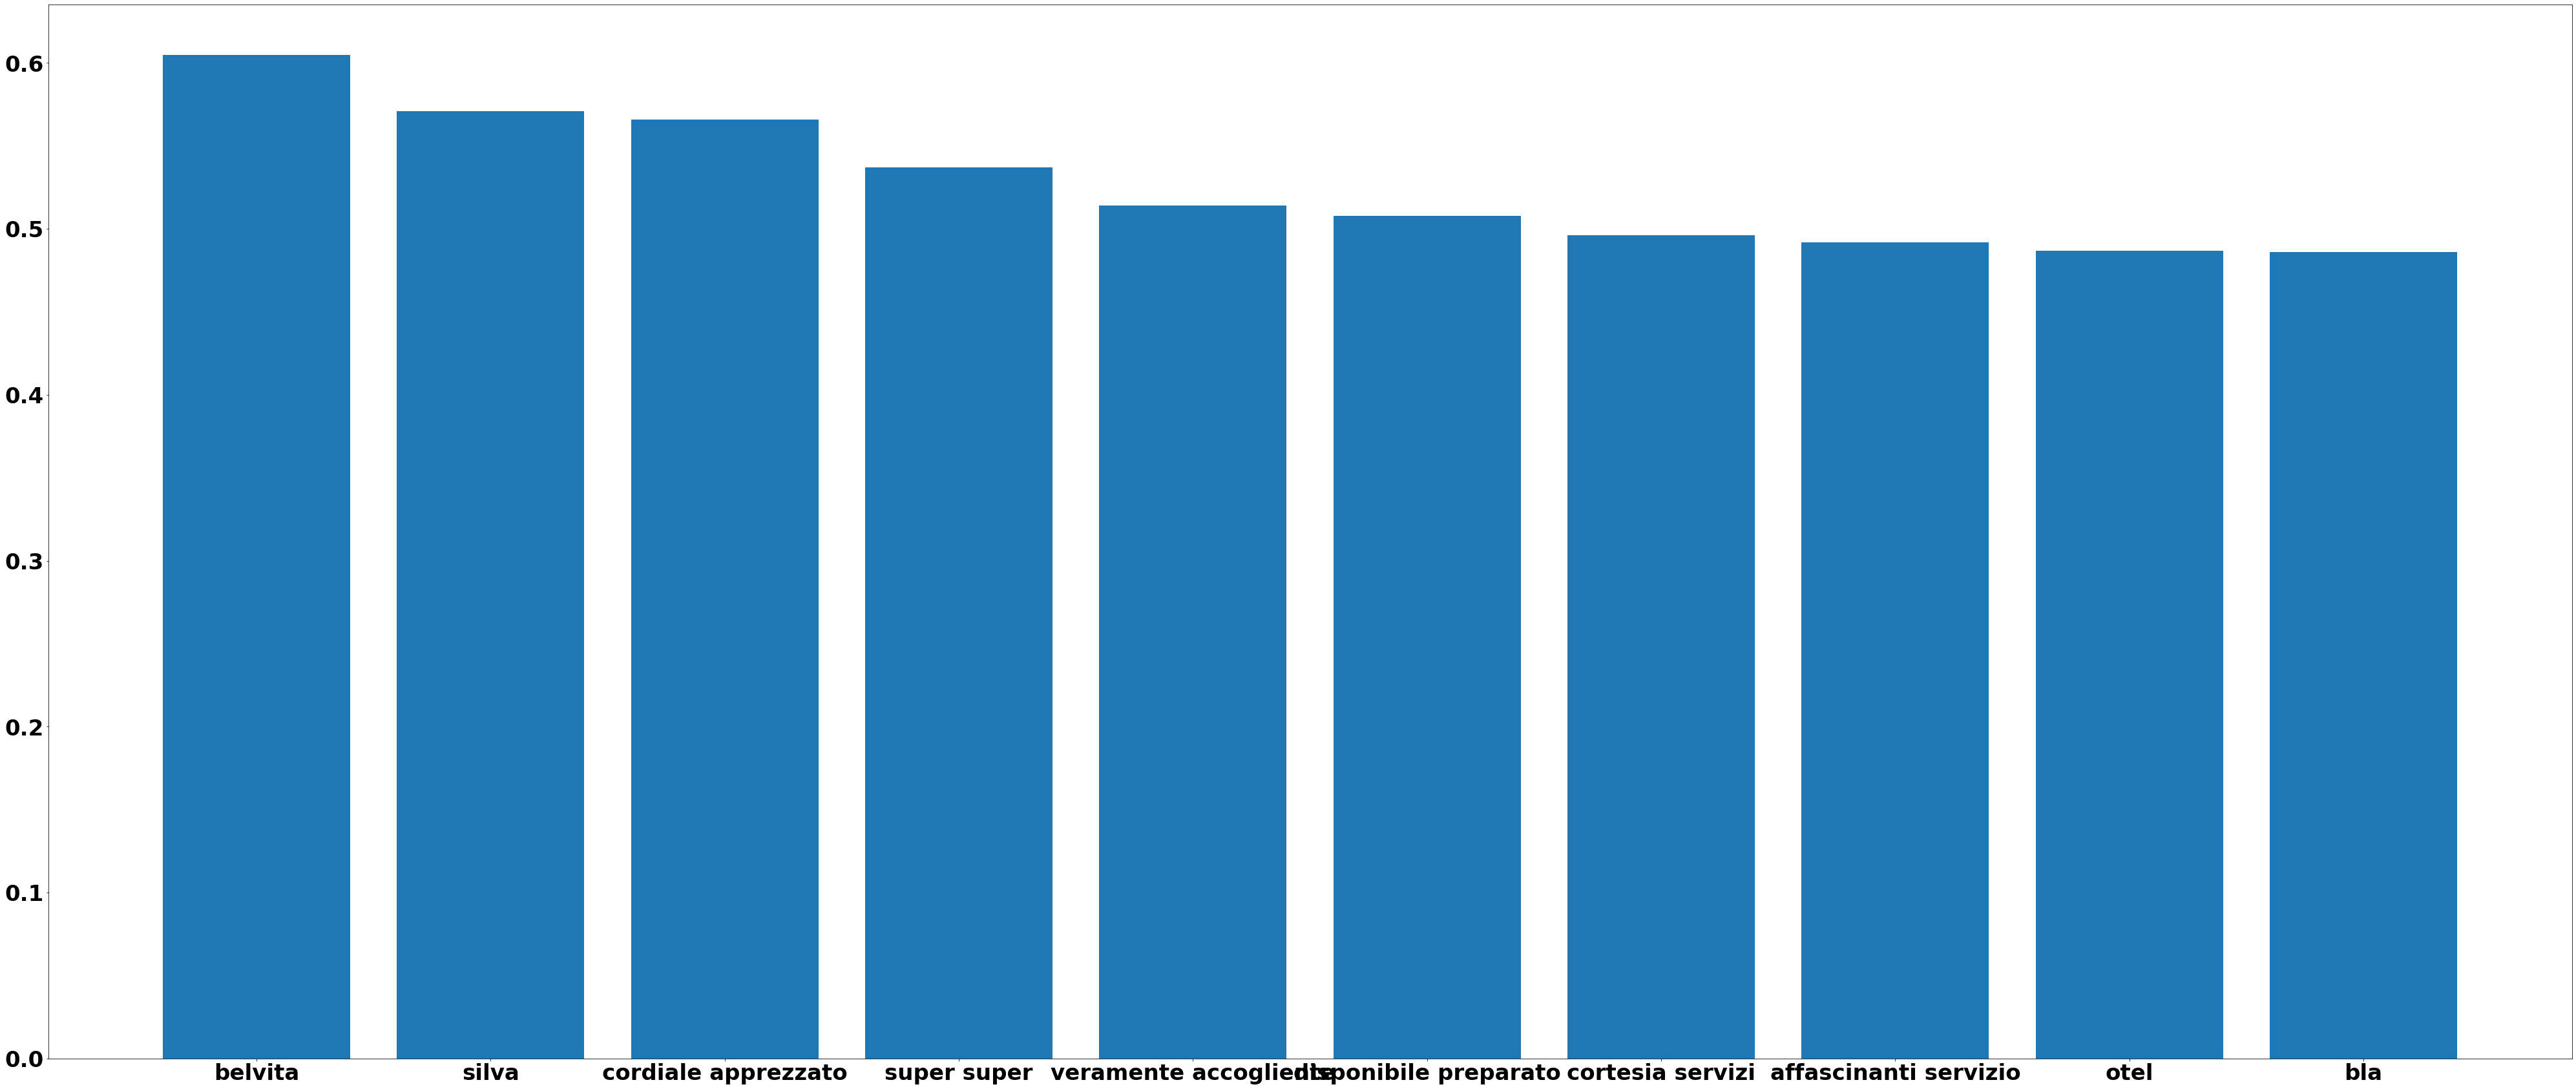

In [157]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 34}

matplotlib.rc('font', **font)
plt.figure(figsize=(70, 30))
plt.bar(x, values)
plt.savefig('keywords.png')

### Read and preprocess data

In [5]:
X = pd.read_csv('development.csv')
test_set = pd.read_csv('evaluation.csv')
y_train = X['class']

In [17]:
X['text'] = X['text'].apply(lambda x:pre_process(x))
test_set['text'] = test_set['text'].apply(lambda x:pre_process(x))
 
#show the second 'text' just for fun
X['text']

0        non è l hotel più lussuoso in cui abbia mai so...
1        siamo stati qui per notte prima della nostra s...
2        hotel è ben posizionato per visitare torino a ...
3        all arrivo la cordialità e disponibilità dello...
4        abbiamo soggiornato per due notti alla fine de...
                               ...                        
28749    l hotel è vecchio ma caratteristico e devo dir...
28750    per essere un stelle l la camera era un pò spa...
28751    io e mia mamma di età compresa tra e siamo sta...
28752    ci siamo sentiti accolti e coccolati fin dall ...
28753    soggiorno fantastico in una posizione fantasti...
Name: text, Length: 28754, dtype: object

### GridSearch and cross validation

In [123]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from stop_words import get_stop_words

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words, use_idf=True,
                              max_df=0.35)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500,
                           class_weight= {'pos':1, 'neg':3},tol=1e-5, n_jobs=-1, alpha=1e-5)),
])

stop_words = get_stop_words('it')

parameters = {}
def my_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label='pos')
f1 = make_scorer(my_f1)
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, scoring=f1)
gs_clf = gs_clf.fit(X['text'], X['class'])

In [128]:
gs_clf.best_estimator_[0]

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.35, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad',
                            'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla',
                            'alle', 'allo', 'allora', 'altre', 'altri', 'altro',
                            'anche', 'ancora', 'avemmo', 'avendo', 'avere',
                            'avesse', 'avessero', 'avessi', 'avessimo',
                            'aveste', 'avesti', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [125]:
gs_clf.best_score_

0.9741635904535512

In [127]:
df = pd.DataFrame()
y_test = gs_clf.predict(test_set['text'])
df['Id'] = [j for j in range(0, y_test.shape[0])]
df['Predicted'] =y_test
df.to_csv('76_fine_tuned_SGD.csv', index=False)

# Setting Vectorizer

In [120]:
# in case u need the emojis use this pattern for any tokenizer: r'[^\s]+'
# vectorizer classes are defined here
# count_vec = CountVectorizer(token_pattern=r'[^\s]+')


tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words, use_idf=True,
                              max_df=0.35)


count_vec.fit(X['text'].values)
tfidf.fit(X['text'].values)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.35, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad',
                            'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla',
                            'alle', 'allo', 'allora', 'altre', 'altri', 'altro',
                            'anche', 'ancora', 'avemmo', 'avendo', 'avere',
                            'avesse', 'avessero', 'avessi', 'avessimo',
                            'aveste', 'avesti', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

### Vectorization

In [8]:
X_train1 = count_vec.transform(X['text'].values)
X_train2 = tfidf.transform(X['text'].values)

# tsvd = TruncatedSVD(n_components=50).fit(X_train2)


### Classification

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

### logistic regression parameters (C)

In [75]:
c_vals = [2000,5000,7000,10000]
c_vals

[2000, 5000, 7000, 10000]

In [76]:
models = []
# X_train=tsvd.transform(X_train2)
for c in tqdm(c_vals):
    model= LogisticRegression(C=c, random_state=700,penalty='l1',solver='liblinear')
    model.fit(X_train2, X['class'])
    models.append(model)
# model=LinearSVC(random_state=0, tol=1e-5)
# model.fit(X_train1, y_train)
probs = pd.DataFrame()
X_test = tfidf.transform(test_set['text'].values)
# X_test=tsvd.transform(X_test)
for i in tqdm(range(len(models))):
    probs['prob_'+str(i)] = models[i].predict_proba(X_test)[:,1]



100%|██████████| 4/4 [00:00<00:00, 76.24it/s]


### undersampling and model averaging

In [158]:
n = 301
# fnumber = 74
transform = 0
name = str(fnumber)+'_'+str(n)+'_probs_c110_log_undrsmpl_tfidf_18k_rep_true_l1_liblinear.csv'
vectorizers = [tfidf, count_vec]
test_set = pd.read_csv('evaluation.csv')

sel_pos = (X['class']=='pos')
sel_neg = (X['class']=='neg')
models = []

for i in tqdm(range(n)):
    X_pos = X[sel_pos].sample(9222, replace=True)
    X_neg = X[sel_neg].sample(9222, replace=True)

    X_balanced = pd.concat([X_neg, X_pos]).sample(frac=1)
    X_train = tfidf.transform(X_balanced['text'].values)
    model = SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=500,
                           tol=1e-5, n_jobs=-1, alpha=1e-5)
    X_balanced['class'] = X_balanced['class'].replace('pos',1)
    X_balanced['class'] = X_balanced['class'].replace('neg',0)
    if transform == 1:
        model.fit(X_train, X_balanced['class'])
    else:
        model.fit(X_train, X_balanced['class'])

    models.append(model)
    
probs = pd.DataFrame()
X_test = tfidf.transform(test_set['text'].values)
loss = 'hing'
for i in tqdm(range(n)):
    if loss=='hing':
        probs['prob_'+str(i)] = models[i].predict(X_test)        
    else:
        probs['prob_'+str(i)] = models[i].predict_proba(X_test)[:,1]
        
probs.to_csv(name, index=False)
fnumber+=1
# X_balanced
    

100%|██████████| 301/301 [00:05<00:00, 59.01it/s] 


In [159]:
y_prob = probs.mean(axis=1)
y_test=y_prob>=0.5
df=pd.DataFrame()
a = []
# i=12
submission_name = 'aggr_'+name
for y in y_test:
    if y:
        a.append('pos')
    else:
        a.append('neg')
df['Id'] = [i for i in range(0, y_test.shape[0])]
df['Predicted'] = a
df.to_csv(submission_name, index=False)

# Best Models Details

In [ ]:
# score :96
SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=10,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.85, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=stop_words,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
# score :96.3
SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=20,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad',
                            'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla',
                            'alle', 'allo', 'allora', 'altre', 'altri', 'altro',
                            'anche', 'ancora', 'avemmo', 'avendo', 'avere',
                            'avesse', 'avessero', 'avessi', 'avessimo',
                            'aveste', 'avesti', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [ ]:
#score :97.41
SGDClassifier(alpha=1e-05, average=False, class_weight={'neg': 3, 'pos': 1},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=1e-05,
              validation_fraction=0.1, verbose=0, warm_start=False)
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.35, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'ad',
                            'adesso', 'agl', 'agli', 'ai', 'al', 'all', 'alla',
                            'alle', 'allo', 'allora', 'altre', 'altri', 'altro',
                            'anche', 'ancora', 'avemmo', 'avendo', 'avere',
                            'avesse', 'avessero', 'avessi', 'avessimo',
                            'aveste', 'avesti', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)
